# RNN-based Stock Prediction with Volatility Analysis

In [16]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

plt.style.use('fivethirtyeight')

## 1. Load Data

In [17]:
file_path = "sp500_data.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "shannanl/sp500-dataset",
    file_path,
)
df.rename(columns={df.columns[0]: "day"}, inplace=True)
print("Data loaded successfully.")
df.head()

/tmp/ipykernel_275514/2739209300.py:2: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Data loaded successfully.


,day,MMM_high,MMM_low,MMM_open,MMM_close,MMM_volume,MMM_adj_close,ABT_high,ABT_low,ABT_open,...,ZION_open,ZION_close,ZION_volume,ZION_adj_close,ZTS_high,ZTS_low,ZTS_open,ZTS_close,ZTS_volume,ZTS_adj_close
0,2000-01-03,48.25000,47.03125,48.03125,47.1875,2173400.0,27.179523,16.160433,15.599306,15.823756,...,59.03125,55.5000,1199600.0,39.500340,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,47.40625,45.31250,46.43750,45.3125,2713800.0,26.099533,15.599306,15.150405,15.459024,...,54.62500,52.8125,816100.0,37.587597,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,48.12500,45.56250,45.56250,46.6250,3699400.0,26.855530,15.402911,15.066236,15.066236,...,52.75000,52.7500,1124700.0,37.543118,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,51.25000,47.15625,47.15625,50.3750,5975800.0,29.015484,15.823756,15.178461,15.262630,...,52.75000,53.5000,1112100.0,38.076908,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,51.90625,49.96875,50.56250,51.3750,4101200.0,29.591490,16.272657,15.487080,15.487080,...,53.75000,53.6250,782000.0,38.165886,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Identify High and Low Volatility Stocks

In [18]:
# Extract all stock symbols from the column names
symbols = sorted(list(set([col.split('_')[0] for col in df.columns if '_' in col])))

# Calculate daily returns for each stock
returns_df = pd.DataFrame()
for symbol in symbols:
    close_col = f'{symbol}_close'
    if close_col in df.columns:
        returns_df[symbol] = df[close_col].pct_change()

# Calculate volatility (standard deviation of daily returns)
volatility = returns_df.std().sort_values(ascending=False)

# Select top 2 high-volatility and bottom 2 low-volatility stocks
high_vol_stocks = volatility.head(2).index.tolist()
low_vol_stocks = volatility.tail(2).index.tolist()
stocks_to_analyze = high_vol_stocks + low_vol_stocks

print(f"High volatility stocks: {high_vol_stocks}")
print(f"Low volatility stocks: {low_vol_stocks}")
print(f"Stocks to analyze: {stocks_to_analyze}")

/tmp/ipykernel_275514/4049056882.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_275514/4049056882.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_275514/4049056882.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = 

High volatility stocks: ['ENPH', 'MRNA']
Low volatility stocks: ['GIS', 'JNJ']
Stocks to analyze: ['ENPH', 'MRNA', 'GIS', 'JNJ']


/tmp/ipykernel_275514/4049056882.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_275514/4049056882.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_275514/4049056882.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

## 3. Train and Evaluate Simple RNN Model

In [19]:
def create_sequences(data, target, time_steps=60):
    """Create sequences of data for RNN."""
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

results_summary = {}
time_steps = 60 # Use 60 days of historical data to predict the next day

for stock in stocks_to_analyze:
    print(f'\n--- Analyzing {stock} ---\n')

    # 1. Prepare Data
    df_stock = utils.load_comp_data(df, stock)
    df_stock_fe = utils.compute_features(df_stock, w=20, cut=False) # Keep NaNs for now
    
    # Separate features and target
    target = df_stock_fe['log_next_day_max_return']
    features = df_stock_fe.drop(columns=["timestep", "log_next_day_max_return"])
    
    # Impute NaNs created by feature engineering
    features.fillna(0, inplace=True)
    target.fillna(0, inplace=True)

    # 2. Scale and Split Data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_features = scaler.fit_transform(features)
    
    split_index = int(0.8 * len(df_stock_fe))
    train_features, test_features = scaled_features[:split_index], scaled_features[split_index:]
    train_target, test_target = target.iloc[:split_index], target.iloc[split_index:]

    # 3. Create Sequences
    X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
    X_test, y_test = create_sequences(test_features, test_target.values, time_steps)
    
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Not enough data to create sequences for {stock}. Skipping.")
        continue

    # 4. Build the Simple RNN model
    model = Sequential([
        SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        SimpleRNN(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25, activation='relu'),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # 5. Train the Model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

    # 6. Evaluate the Model
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results_summary[stock] = {'R2': r2, 'MSE': mse}
    
    print(f'\nEvaluation for {stock}:')
    print(f'R2 Score: {r2:.4f}')
    print(f'MSE: {mse:.6f}')


--- Analyzing ENPH ---



/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
2025-11-15 18:58:47.008972: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         4,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,351 (40.43 KB)

 Trainable params: 10,351 (40.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0504 - val_loss: 0.0072
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0166 - val_loss: 0.0054
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0100 - val_loss: 0.0032
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0071 - val_loss: 0.0032
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 11/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 12/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 60, 50)         │         4,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,351 (40.43 KB)

 Trainable params: 10,351 (40.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.1017 - val_loss: 0.0090
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0290 - val_loss: 0.0035
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0196 - val_loss: 0.0055
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0140 - val_loss: 0.0019
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0097 - val_loss: 0.0017
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0081 - val_loss: 0.0019
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0

/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 60, 50)         │         4,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,351 (40.43 KB)

 Trainable params: 10,351 (40.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0458 - val_loss: 5.1324e-04
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0019 - val_loss: 1.8554e-04
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 6.3630e-04 - val_loss: 2.2664e-04
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.7021e-04 - val_loss: 1.1850e-04
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.8834e-04 - val_loss: 7.3817e-05
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.3391e-04 - val_loss: 7.9234e-05
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7560e-04 - val_loss: 6.6769e-05
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.3036e-04 - val_loss: 6.6374e-05
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.2753e-04 - val_loss: 6.6602e-05
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.0544e-04 - val_loss: 6.7006e-05
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - l

/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 60, 50)         │         4,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,351 (40.43 KB)

 Trainable params: 10,351 (40.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0234 - val_loss: 4.8746e-05
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0011 - val_loss: 5.7319e-05
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.0335e-04 - val_loss: 4.7698e-05
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.8946e-04 - val_loss: 4.7849e-05
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.4763e-04 - val_loss: 4.7417e-05
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5525e-04 - val_loss: 5.2364e-05
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4554e-04 - val_loss: 4.7370e-05
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4331e-04 - val_loss: 5.0046e-05
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.3792e-04 - val_loss: 4.9569e-05
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.2127e-04 - val_loss: 5.3126e-05
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - l

## 4. Compare Model Performance


--- RNN Model Performance Summary ---
            R2       MSE
ENPH -0.019582  0.001634
MRNA  0.006417  0.001317
GIS  -0.055811  0.000137
JNJ  -0.002251  0.000095


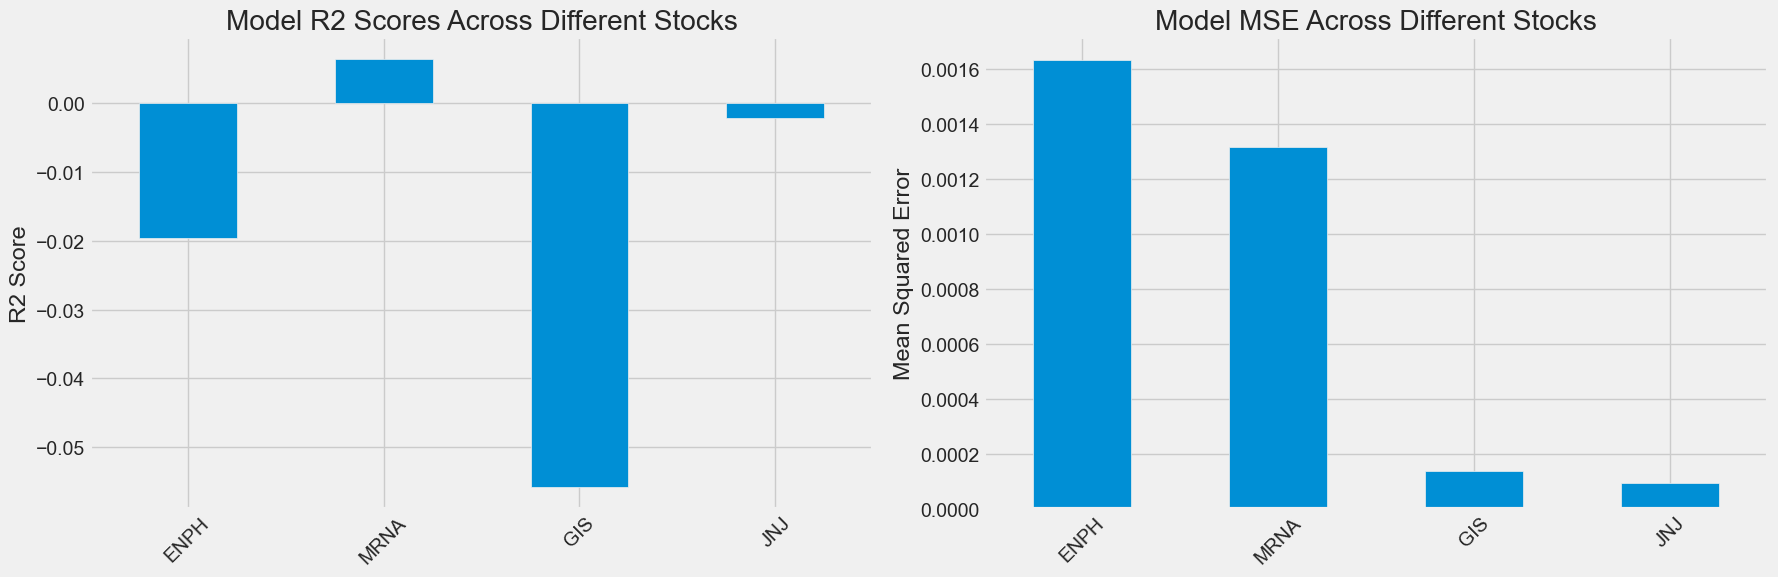

In [20]:
df_results = pd.DataFrame(results_summary).T
print("\n--- RNN Model Performance Summary ---")
print(df_results)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=False)
df_results['R2'].plot(kind='bar', ax=axes[0], title='Model R2 Scores Across Different Stocks')
axes[0].set_ylabel('R2 Score')
axes[0].tick_params(axis='x', rotation=45)

df_results['MSE'].plot(kind='bar', ax=axes[1], title='Model MSE Across Different Stocks')
axes[1].set_ylabel('Mean Squared Error')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()